# Binary Image Classification using Logistic regression

### overview
in Binary Classification your are provided with attribute and you have to predict whether the tuple belongs to that class or not
for example for an image 

![alt text](https://images.pexels.com/photos/104827/cat-pet-animal-domestic-104827.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500) 

you have to predict whether it belongs to that class( yhat = 1) or not  (yhat = 0) in this case the class label is a cat

and we are going to this with logistic regression the basic idea behind logistic regression is a follows

given $x$ you have to find $\hat{y}$ = P$(y = 1 | x)$ <br>
wheer P$(y = 1 | x)$ is the probability of class label y to be 1 given $x$


so we will start by looking at our dataset
 but before that we need to import the important modules 

 theses are 
 -  [numpy](https://dzoyjhywvvhywqiayprlkm.coursera-apps.org/notebooks/Week%202/Logistic%20Regression%20as%20a%20Neural%20Network/www.numpy.org)
 -  [matplotlib](http://matplotlib.org/)
 -  PIL and SciPy for reading image data
 -  h5py for loading h5 files

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from scipy import ndimage
import h5py 
import scipy
import PIL

In [0]:
import warnings

warnings.filterwarnings("ignore")

our data is in the form of h5 files so we need to first create a method to load this dataset into proper format using numpy and h5py

In [0]:
train_data = h5py.File('/content/train_catvnoncat.h5' , "r" )
train_set_x_real = np.array(train_data['train_set_x'][:])
train_set_y_real = np.array(train_data['train_set_y'][:])

test_data = h5py.File("/content/test_catvnoncat.h5" , "r")
test_set_x_real = np.array(test_data['test_set_x'][:])
test_set_y_real = np.array(test_data["test_set_y"][:])

classes = np.array(test_data["list_classes"][:])

train_set_y_real = train_set_y_real.reshape(1, train_set_y_real.shape[0])
test_set_y_real = test_set_y_real.reshape(1, test_set_y_real.shape[0])

so now our data set is loaded
- train_set_x_real
- train_set_y_real
- test_set_x_real
- test_set_y_real

now lets look at some example images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  # This is added back by InteractiveShellApp.init_path()


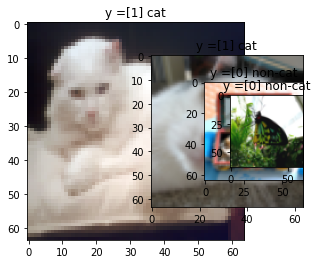

In [20]:
index = 13

fig = plt.figure()
x = 1
for i in range(index , index+4):
    ax = fig.add_subplot(1 , x, x)
    ax.imshow(train_set_x_real[i])
    ax.set_title("y =" + str(train_set_y_real[:,i]) +" "+ classes[np.squeeze(train_set_y_real[:,i])].decode("utf-8"))
    x+= 1

fig.tight_layout(pad=10)
fig.show()

now lets move further

first look at the shape of our images and datasets

In [33]:
print("# images in our training set = " + str(train_set_x_real.shape[0]))
print("# images in our testing set = " + str(test_set_x_real.shape[0]))
print("# pixels in each channel (R,G,B) = " + str(train_set_x_real.shape[1]))
print("shape of training images = " + str(train_set_x_real.shape))
print("shape of training labels = " + str(train_set_y_real.shape))
print("shape of testing images = " + str(test_set_x_real.shape))
print("shape of testing labels = " + str(test_set_y_real.shape))

# images in our training set = 209
# images in our testing set = 50
# pixels in each channel (R,G,B) = 64
shape of training images = (209, 64, 64, 3)
shape of training labels = (1, 209)
shape of testing images = (50, 64, 64, 3)
shape of testing labels = (1, 50)


<h4> so we can see that each image is of the shape 
$(64 , 64 , 3)$  but we need to convert it into a vector of shape $(64*64*3, 1)$

this is called flattening the image so lets do it 

so for our whole training set with shape $(209 , 64 , 64, 3) $  we have convert it into the shape $(64*64*3 , 209)$
and same we have to for our testing set

In [0]:
train_set_x_real = train_set_x_real.reshape(train_set_x_real.shape[0] , -1).T
test_set_x_real = test_set_x_real.reshape(test_set_x_real.shape[0] , -1).T

now lets look at the shape

In [35]:
print("shape of training set = " + str(train_set_x_real.shape))
print("shape of testing set = " + str(test_set_x_real.shape) )

shape of training set = (12288, 209)
shape of testing set = (12288, 50)


logistic regression consist of two processes *forward propagation* and *backward propagation*

#### forward propagation
it computes yhat using the equation <br>
$$\hat{y} = \sigma(z)$$ <br>
where $ z =  w^T.x + b$, <br>
$w$ is the weight matrix and $b$ is the bias <br>
and $\sigma(x)$ is the sigmoid function that is $\sigma(x) = \frac{1}{1+ e^{-x}}$ <br>
and compute cost using
$$  J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$
where $J$ is the cost and $\mathcal{L}(a^{(i)}, y^{(i)}) = - y^{(i)} \log(a^{(i)}) - (1-y^{(i)} ) \log(1-a^{(i)})\tag{3}$
#### backward propagation
computes derivatives for gradient descent to update and optimise the parameters $w$ and $b$ <br>

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

where $J$ is the total cost

first lets create the sigmoid function

In [36]:
def sigmoid(z):
    """
    computes sigmoid of z
    """
    result = 1 / (1 + np.exp(-z))
    return result

#test
sigmoid(54)

1.0

now first we need to initialize the weight and bias with zeroes

In [0]:
def initialize_params(dims):
    """
    dims = size of w
    """
    w = np.zeros((dims , 1))
    b = 0
    return w , b

In [0]:
def propagate(w , b, X , Y):
    """
    w - wieght
    b - bias
    X - training data
    Y - training labels

    retrun
    J - total cost
    dw - derivative of J w.r.t.  'w'
    db - derivative of J w.r.t.  'b"

    """
    m = X.shape[0]

    ## forward prop
    A = sigmoid(np.dot(w.T , X) + b)

    cost = -(np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)))/ m

    ## backward prop
    dw = (np.dot(X , (A-Y).T))/m
    db = (np.sum(A - Y))/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw" : dw , "db": db}

    return grads , cost



now lets create the function for gradient descent which will optimize our parameters

as follows

$$ w = w - \alpha*dw $$
$$ b = b - \alpha*db $$
where $\alpha$ is the learning rate
 and this process iterate multiple times

In [0]:
def optimize_parameters(w , b, X , Y , num_iteration = 2000 , learning_rate = 0.05):
    """
    return - grads , parama optimized , cost reduced
    """
    costs  = []
    for i in range(num_iteration):
        grads , cost = propagate(w , b, X,Y)
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate*dw
        w = w - learning_rate*db

        if (i % 100 == 0):
            costs.append(cost)

    params = {"w" : w , "b":b}
    grads = {"dw" : dw , "db" : db}

    return params , grads , costs


In [89]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
params, grads, costs = optimize_parameters(w, b, X, Y, num_iteration= 100, learning_rate = 0.009)
costs

[8.70231797909183]

now lets create the predict method to predict the labels for our testing set

In [0]:
def predict(w , b, X):
    m = X.shape[1]
    y_preds = np.zeros((1, m))
    w = w.reshape(X.shape[0] , 1)

    A = sigmoid(np.dot(w.T , X) + b)

    for i in range(A.shape[1]):
        y_preds[0, i] = np.round(A[0, i])

    assert(y_preds.shape == (1 , m))

    return y_preds

so now all our methods are ready now lets combine this to form our model

In [0]:
def log_reg_model(X_train , Y_train , X_test , Y_test , num_iteration = 2000 , learning_rate = 0.05):
    dim = X_train.shape[0]
    w , b = initialize_params(dim)

    params , grads , costs = optimize_parameters(w, b, X_train , Y_train , num_iteration , learning_rate)
    w = params["w"]
    b = params["b"]

    y_pred_test = predict(w , b, X_test)
    y_pred_train = predict(w , b, X_train)

    test_accuracy = 100 - np.mean(np.abs(y_pred_test - Y_test)) * 100
    train_accuracy = 100 - np.mean(np.abs(y_pred_train - Y_train)) * 100

    print("train accuracy = " + str(train_accuracy) +"%")
    print("test accuracy = " + str(test_accuracy) + "%")

    cache = {
        "w": w,
        "b":b,
        "costs": costs,
        "y_prediction_test": y_pred_test,
        "y_prediction_train": y_pred_train,
        "learning_rate":learning_rate,
        "num_iteration" : num_iteration
    }

    return cache

so now our model is ready we can now apply it to our data set

In [82]:
cache = log_reg_model(train_set_x_real , train_set_y_real , test_set_x_real , test_set_y_real)

train accuracy = 100.0%
test accuracy = 72.0%


now lets look at the prediction of opur model

y = 1 prediction = 1.0


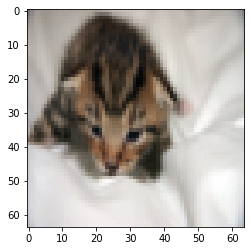

In [83]:
num_px = 64
index = 1
plt.imshow(test_set_x_real[:, index].reshape(num_px , num_px , 3))
print("y = "+ str(test_set_y_real[0,index]) + " prediction = " + str(cache["y_prediction_test"][0,index]))

now lets test our model on a random image

predicted  = [[1.]]


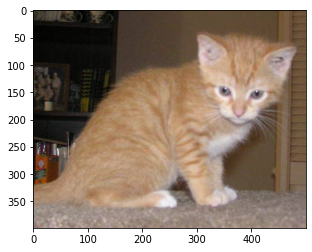

In [108]:
my_image = "/content/dataset/test_set/cats/cat.4003.jpg"
image = np.array(plt.imread(my_image))
#my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_image = np.array(Image.fromarray(image).resize((num_px , num_px))).reshape((1 , num_px *num_px *3)).T
my_predicted_image = predict(cache["w"], cache["b"], my_image)

plt.imshow(image)
print("predicted  = " + str(my_predicted_image))

lets create a flatten image method which will help us to flatten and resize any external image according to models requirements

In [0]:
def flatten(path):
    image = np.array(plt.imread(path))
    im_flatten = np.array(Image.fromarray(image).resize((num_px , num_px))).reshape((1 , num_px *num_px *3)).T

    return image , im_flatten

now this is it our model using logistic regression is ready